# Gaussian processes

Credit to https://peterroelants.github.io/posts/gaussian-process-tutorial/.

- Gaussian processes are nonparametric, supervised learning method.

- Gaussian processes in a nutshell: given X1 and Y1, make prediction Y2 for X2. Both (X1, Y1) and (X2, Y2) come from the same Gaussian distribution. 
- The prediction of Y2 is not unique, but rather is drawn from a Gaussian distribution with mean of $\mu_{2|1}$ and variance of $\sigma2_{2|1}$. $\mu_{2|1}$ and $\sigma2_{2|1}$ are solved using

    $\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
    \sim
    \mathcal{N} \left(
    \left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
    \left[ \begin{array}{cc}
    \sigma2_{11} & \sigma2_{12} \\
    \sigma2_{21} & \sigma2_{22}
    \end{array} \right]
    \right)$

    \begin{split}
    p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \sigma2_{2|1}) \\
    \mu_{2|1} & = \mu_2 + \sigma2_{21} \sigma2_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
            & = \sigma2_{21} \sigma2_{11}^{-1} \mathbf{y}_1 \quad (\text{if assume mean prior }  \mu = 0 ) \\
    \sigma2_{2|1} & = \sigma2_{22} - \sigma2_{21} \sigma2_{11}^{-1}\sigma2_{12}
    \end{split}

- The $\sigma2_{2|1}$ is obtained using a "covariance function", or called "kernel function", where the function takes in X1 and X2 and measures the cross "distance" between them. Therefore, the prediction is made by interpolates the observations.
    - The choice of the covariance function is a form of hyperparameter. Since the choice needs to be made apriori of the gaussian process, it's a prior.
    - A common covariance function to use is the exponentiated quadratic covariance function. It's also known as the radical basis function. This is because X1 can be viewed as the central point of a circle, and this kernel valuates some form of radial distance.

- Disadvantges:
    - Becomes expensive in high dimensionl space due to the need for cross distance evaluation for calculating covariance function.

## From scratch

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [6]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb, sigma2=1):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 / sigma2**2 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [7]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func, mean=0):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = mean + solved @ (y1 - mean)
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [38]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_truth = lambda x: (x * np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_truth(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)


Text(0, 0.5, 'y = f(x)')

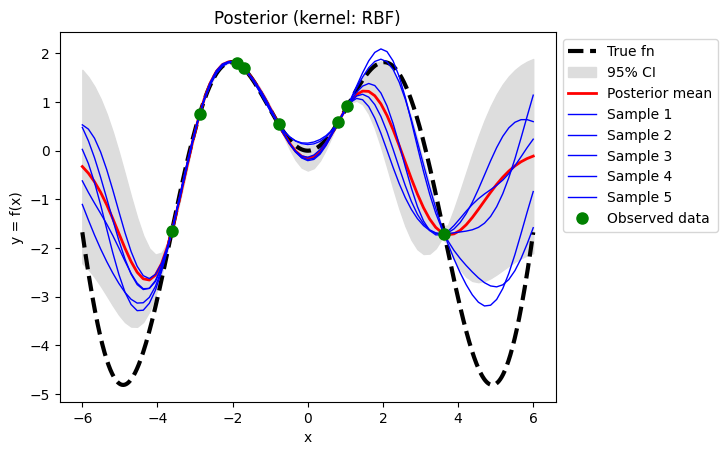

In [39]:
plt.figure()
xs = np.linspace(*domain, 1000).reshape(-1, 1)
plt.plot(xs, f_truth(xs), 'k', lw=3, ls='--', label='True fn')
plt.gca().fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color="#dddddd", label='95% CI')
plt.plot(X2, μ2, 'r', lw=2, label='Posterior mean')
plt.plot(X2, y2.T, 'b', lw=1, label=[f'Sample {i+1}' for i in range(ny)])
plt.plot(X1, y1, 'go', ms=8, label='Observed data')
plt.title("Posterior (kernel: RBF)")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("x")
plt.ylabel("y = f(x)")

## Compact

In [52]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [62]:
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp.fit(X1, y1)
mu2, sigma2 = gp.predict(X2, return_std=True)
Y2 = gp.sample_y(X2, n_samples=5, random_state=0)



Text(0, 0.5, 'y = f(x)')

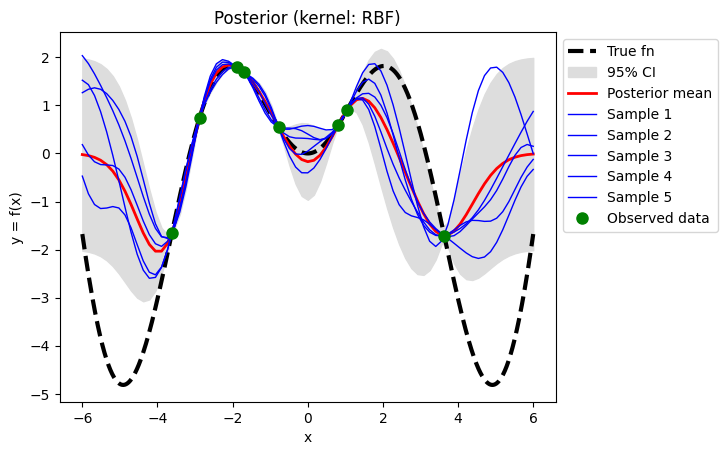

In [63]:
plt.figure()
plt.plot(xs, f_truth(xs), 'k', lw=3, ls='--', label='True fn')
plt.gca().fill_between(X2.flat, mu2-2*sigma2, mu2+2*sigma2, color="#dddddd", label='95% CI')
plt.plot(X2, mu2, 'r', lw=2, label='Posterior mean')
plt.plot(X2, Y2, 'b', lw=1, label=[f'Sample {i+1}' for i in range(ny)])
plt.plot(X1, y1, 'go', ms=8, label='Observed data')
plt.title("Posterior (kernel: RBF)")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("x")
plt.ylabel("y = f(x)")